# Project 3: Advanced Running Retargeting using NLP

---
## Part 4: EDA

This section combines the exploratory data analysis for multiple sections. The first section is EDA prior to vectorizing, the second section is EDA after vectorizing and the third section is EDA after modeling. 

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import re
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Read in cleaned csv
runners=pd.read_csv('../data/sent_lemma.csv')
tvec=pd.read_csv('../data/tvec_words.csv')

#reading in X_train, X_test, y_train and y_test
X_train=pd.read_csv('../data/X_train_vec.csv')
X_test=pd.read_csv('../data/X_test_vec.csv')
y_train=pd.read_csv('../data/y_train.csv')
y_test=pd.read_csv('../data/y_test.csv')
coef_df=pd.read_csv('../data/logreg_coef_df.csv')

In [3]:
runners.head()

,author,post,is_advanced,post_length,post_word_count,neg,pos,neu,compound,tok_pos_lemma_post
0,Brojadyn2006,"Further college running Hello, so I was wonder...",1,511,95,0.028,0.077,0.895,0.6801,further college run hello so i be wonder for s...
1,Tea-reps,Race Report: Big breakthrough at the Boston Ha...,1,8090,1406,0.044,0.144,0.813,0.9993,race report big breakthrough at the boston hal...
2,Caffeinated262,Garden of Life Palm Beaches Marathon I have th...,1,440,82,0.000,0.147,0.853,0.9078,garden of life palm beach marathon i have the ...
3,blueheeler9,2022 BAA Half Marathon | Wet &amp; Glorious 1:...,1,7512,1379,0.046,0.119,0.835,0.9987,2022 baa half marathon wet amp glorious 1 26 o...
4,zzach_519,2022 Berkeley Half race report ### Race Inform...,1,6934,1277,0.041,0.106,0.853,0.9979,2022 berkeley half race report race informatio...


### Section 1: EDA Pre-Vectorizing

#### Summary statistics for the combined data frame 
- While there are some outliers in post_length and post_word_count, I chose to leave them as they could be important for predictions

In [4]:
#Summary Statistics for Sentiment Analysis/feature engineered cols 
sa_fe=runners[['neg', 'pos', 'neu', 'compound', 'post_length', 'post_word_count']]
sa_fe.describe().T

,count,mean,std,min,25%,50%,75%,max
neg,13572.0,0.054595,0.056281,0.0000,0.010,0.04300,0.0800,0.773
pos,13572.0,0.112994,0.073432,0.0000,0.065,0.10600,0.1490,0.678
neu,13572.0,0.832408,0.084167,0.2270,0.784,0.83700,0.8860,1.000
compound,13572.0,0.441677,0.627153,-0.9985,0.000,0.74405,0.9388,1.000
post_length,13572.0,1136.633731,1999.189621,14.0000,342.000,590.00000,1039.2500,37797.000
post_word_count,13572.0,208.339154,365.501491,2.0000,63.000,109.00000,192.0000,7132.000


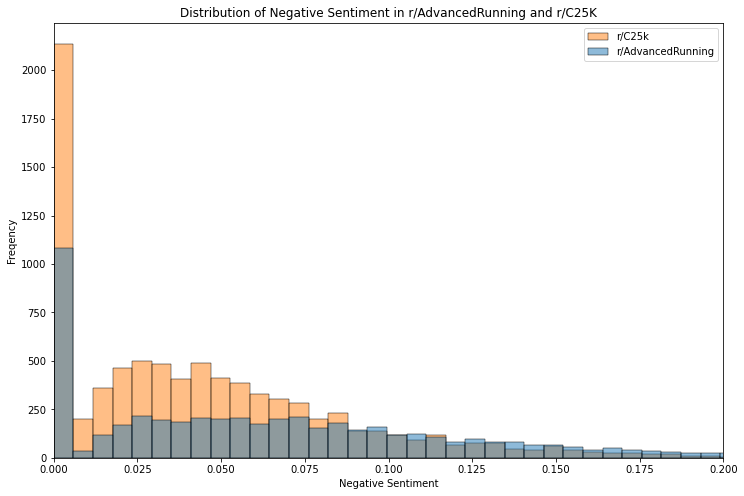

In [126]:
#Distribution of negative sentiment analysis 
plt.figure(figsize=(12,8))
sns.histplot(data=runners, x='neg', hue='is_advanced')
plt.title('Distribution of Negative Sentiment in r/AdvancedRunning and r/C25K')
plt.ylabel('Freqency')
plt.xlabel('Negative Sentiment')
plt.legend(['r/C25k','r/AdvancedRunning'])
plt.xlim((0,.2))
plt.show();

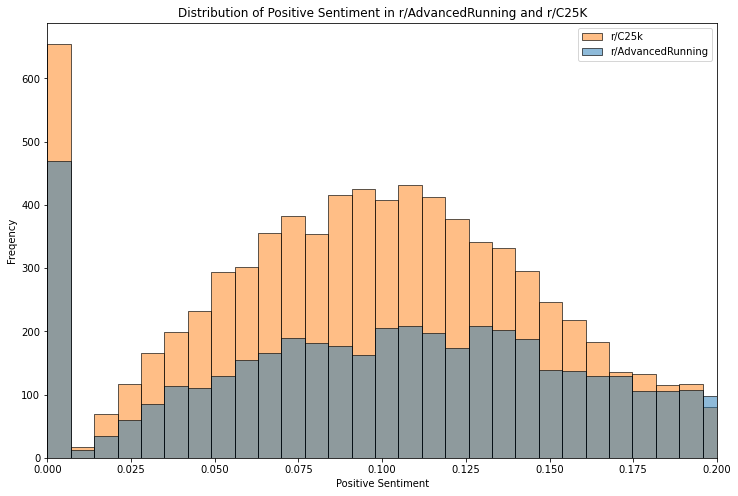

In [127]:
#Distribution of postive sentiment 
plt.figure(figsize=(12,8))
sns.histplot(data=runners, x='pos', hue='is_advanced')
plt.title('Distribution of Positive Sentiment in r/AdvancedRunning and r/C25K')
plt.ylabel('Freqency')
plt.xlabel('Positive Sentiment')
plt.legend(['r/C25k','r/AdvancedRunning'])
plt.xlim((0,.2))
plt.show();

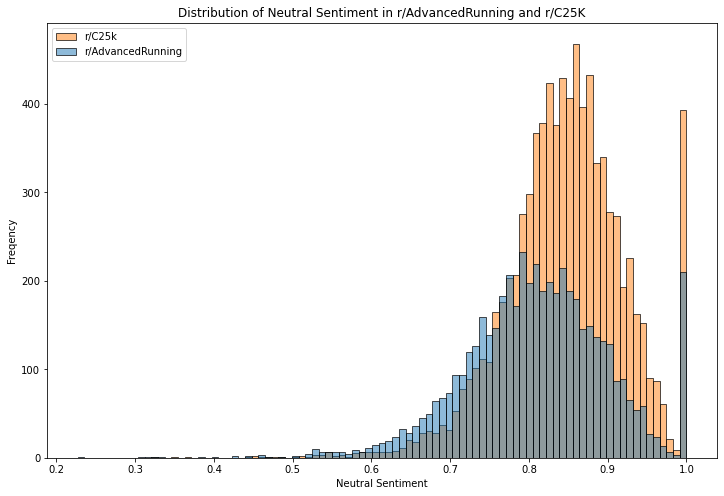

In [129]:
#Distribution of neutral sentiment 
plt.figure(figsize=(12,8))
sns.histplot(data=runners, x='neu', hue='is_advanced')
plt.title('Distribution of Neutral Sentiment in r/AdvancedRunning and r/C25K')
plt.ylabel('Freqency')
plt.xlabel('Neutral Sentiment')
plt.legend(['r/C25k','r/AdvancedRunning'])
#plt.xlim((0,.2))
plt.show();

#### Summary Statistics for/AdvancedRunning and r/C25K indivdually
- Prior to modeling, r/C25k has a slightly higher negative sentiment and positive sentiment, while r/AdvancedRunning has a slightly higher neutral sentiment 

In [5]:
#Creating a variable for EDA on is_advanced
is_advanced_eda=runners.loc[runners['is_advanced']==1]
c25k_eda=runners.loc[runners['is_advanced']==0]

In [6]:
#Summary Statistics for r/Advanced Running 
is_advanced_eda[['neg', 'pos', 'neu', 'compound', 'post_length', 'post_word_count']].describe().T

,count,mean,std,min,25%,50%,75%,max
neg,8440.0,0.046320,0.049055,0.0000,0.00000,0.0370,0.0680,0.677
pos,8440.0,0.106783,0.066865,0.0000,0.06400,0.1020,0.1410,0.552
neu,8440.0,0.846896,0.076033,0.3230,0.80300,0.8495,0.8940,1.000
compound,8440.0,0.500537,0.596751,-0.9979,0.17985,0.7897,0.9539,1.000
post_length,8440.0,1458.842536,2440.425197,14.0000,390.00000,698.0000,1283.0000,37797.000
post_word_count,8440.0,264.209123,446.556421,2.0000,70.00000,127.0000,234.0000,7132.000


In [7]:
#Summary Statistics for r/C25k
c25k_eda[['neg', 'pos', 'neu', 'compound', 'post_length', 'post_word_count']].describe().T

,count,mean,std,min,25%,50%,75%,max
neg,5132.0,0.068204,0.064205,0.0000,0.020000,0.0570,0.100000,0.773
pos,5132.0,0.123207,0.082104,0.0000,0.067000,0.1150,0.168000,0.678
neu,5132.0,0.808582,0.091189,0.2270,0.753000,0.8100,0.867000,1.000
compound,5132.0,0.344876,0.662969,-0.9985,-0.222775,0.6507,0.908725,0.999
post_length,5132.0,606.734606,569.273904,17.0000,285.000000,472.5000,753.250000,12203.000
post_word_count,5132.0,116.456352,108.544623,2.0000,55.000000,91.0000,145.000000,2289.000


#### Distributions for relationships in r/AdvancedRunning and r/C25k
- A x-limit was placed on the outliers in the post length and post_word_count distributions for both r/AdvancedRunning and r/C25k in order to make the data more readable. 

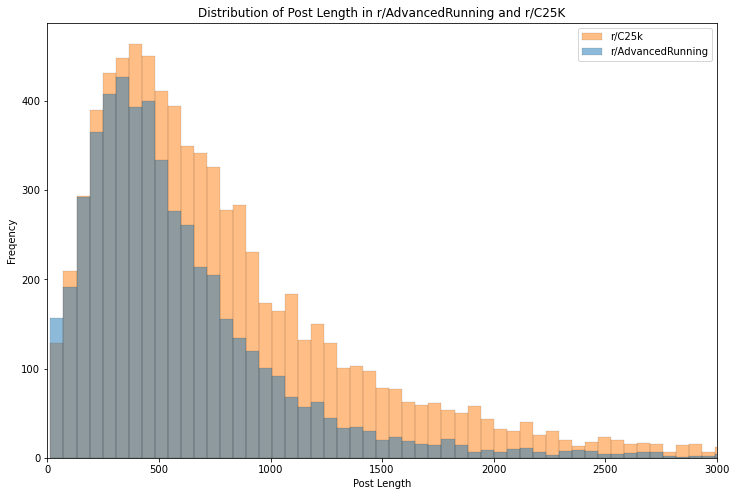

In [134]:
#Distribution of post_length
plt.figure(figsize=(12,8))
sns.histplot(data=runners, x='post_length', hue='is_advanced')
plt.title('Distribution of Post Length in r/AdvancedRunning and r/C25K')
plt.ylabel('Freqency')
plt.xlabel('Post Length')
plt.legend(['r/C25k','r/AdvancedRunning'])
plt.xlim((0,3000))
plt.show();

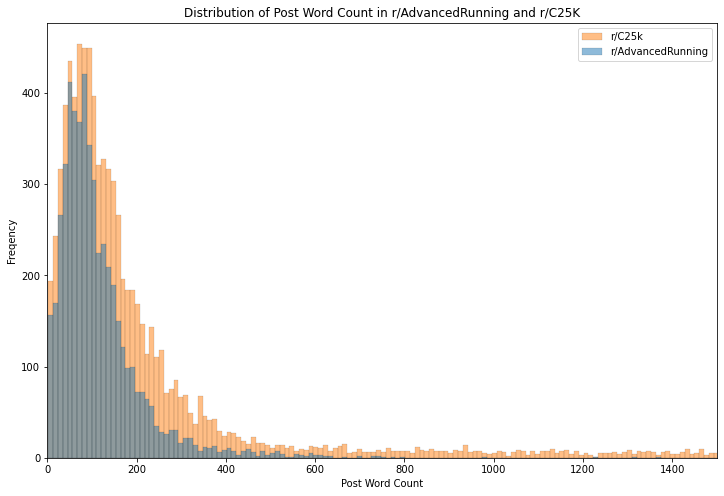

In [137]:
#Distribution of word count 
plt.figure(figsize=(12,8))
sns.histplot(data=runners, x='post_word_count', hue='is_advanced')
plt.title('Distribution of Post Word Count in r/AdvancedRunning and r/C25K')
plt.ylabel('Freqency')
plt.xlabel('Post Word Count')
plt.legend(['r/C25k','r/AdvancedRunning'])
plt.xlim((0,1500))
plt.show();

### Section 2: EDA after Vectorizing 
- The following graphs are the top 20 words after CountVectorizing. The first set of each graphs includes numerical features, while the second set contains all non-numeric features.  

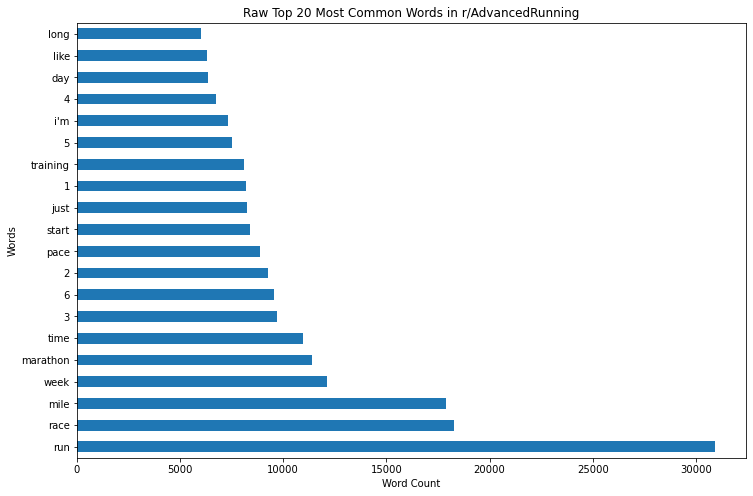

In [96]:
#EDA Cvec on is_advanced 
advanced_cvec=CountVectorizer(stop_words='english', token_pattern=r'[\w\'\']+')
advanced_cvec.fit(is_advanced_eda['tok_pos_lemma_post'])
advanced_eda=advanced_cvec.transform(is_advanced_eda['tok_pos_lemma_post'])

# Convert advanced_cvec into a DataFrame.
advanced_cvec_df = pd.DataFrame(advanced_eda.todense(), columns=advanced_cvec.get_feature_names())

# plot top occuring words
plt.figure(figsize=(12,8))
advanced_cvec_df.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title('Raw Top 20 Most Common Words in r/AdvancedRunning')
plt.ylabel('Words')
plt.xlabel('Word Count');

In [13]:
#function to remove numbers in count vec
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    return text

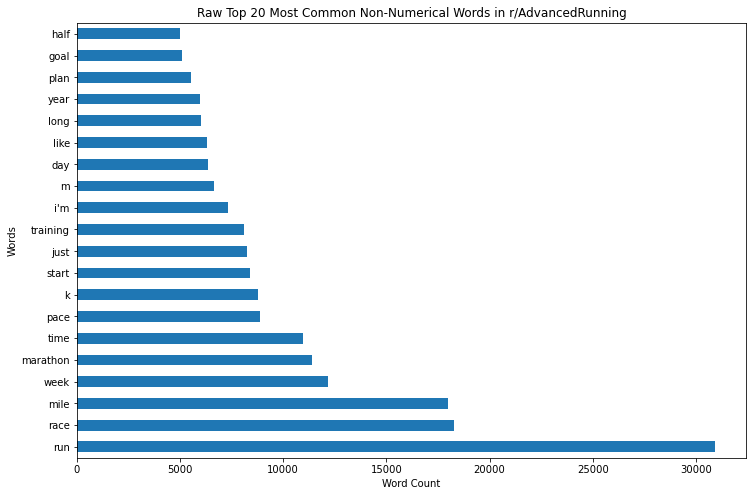

In [85]:
#Taking numbers out of is_advanced 
advanced_cvec_nonum=CountVectorizer(stop_words='english', token_pattern=r'[\w\'\']+', preprocessor=preprocess_text)
advanced_cvec_nonum.fit(is_advanced_eda['tok_pos_lemma_post'])
advanced_eda_nonum=advanced_cvec_nonum.transform(is_advanced_eda['tok_pos_lemma_post'])

# Convert advanced_cvec into a DataFrame.
advanced_cvec_nonum_df = pd.DataFrame(advanced_eda_nonum.todense(), columns=advanced_cvec_nonum.get_feature_names())

# plot top occuring words
plt.figure(figsize=(12,8))
advanced_cvec_nonum_df.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title('Raw Top 20 Most Common Non-Numerical Words in r/AdvancedRunning') 
plt.ylabel('Words')
plt.xlabel('Word Count');

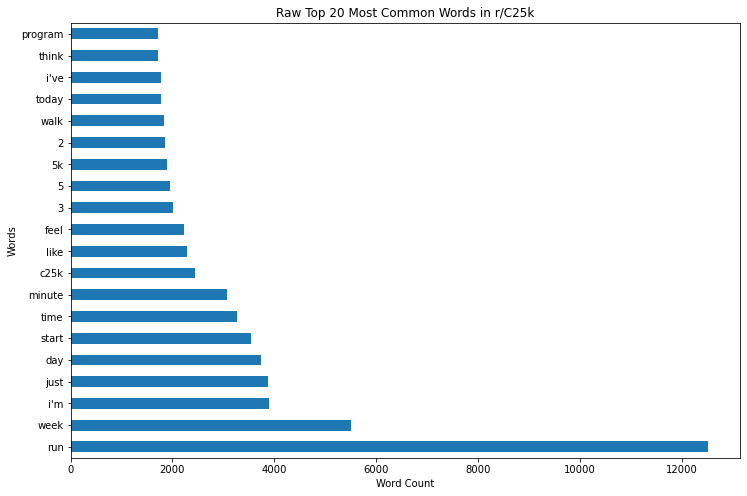

In [90]:
#EDA Cvec on c25k
c25k_cvec=CountVectorizer(stop_words='english', token_pattern=r'[\w\'\']+')
c25k_cvec.fit(c25k_eda['tok_pos_lemma_post'])
c25ks_eda=c25k_cvec.transform(c25k_eda['tok_pos_lemma_post'])

# Convert advanced_cvec into a DataFrame.
c25k_cvec_df = pd.DataFrame(c25ks_eda.todense(), columns=c25k_cvec.get_feature_names())

# plot top occuring words
plt.figure(figsize=(12,8))
c25k_cvec_df.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title('Raw Top 20 Most Common Words in r/C25k')
plt.ylabel('Words')
plt.xlabel('Word Count');

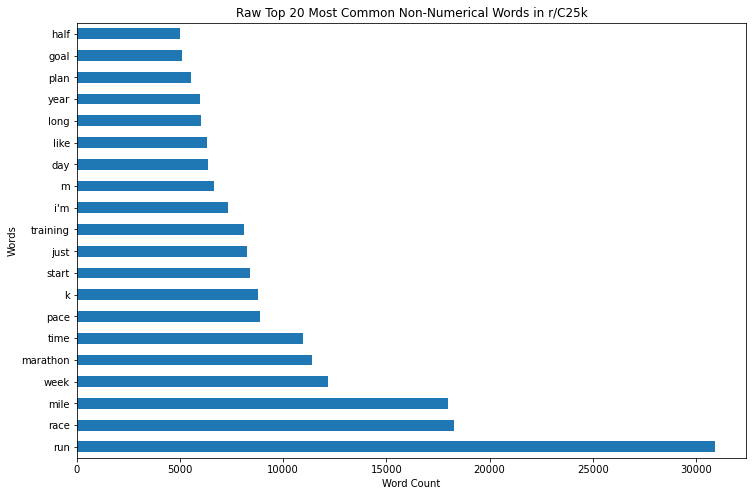

In [97]:
#taking numbers out of c25k
c25k_cvec_nonum=CountVectorizer(stop_words='english', token_pattern=r'[\w\'\']+', preprocessor=preprocess_text)
c25k_cvec_nonum.fit(is_advanced_eda['tok_pos_lemma_post'])
c25ks_eda_nonum=c25k_cvec_nonum.transform(is_advanced_eda['tok_pos_lemma_post'])

# Convert advanced_cvec into a DataFrame.
c25k_cvec_nonum_df = pd.DataFrame(c25ks_eda_nonum.todense(), columns=c25k_cvec_nonum.get_feature_names())

# plot top occuring words
plt.figure(figsize=(12,8))
c25k_cvec_nonum_df.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title('Raw Top 20 Most Common Non-Numerical Words in r/C25k') 
plt.ylabel('Words')
plt.xlabel('Word Count');

### Section 3: EDA after Modeling

- coef_df includes the coefficient and odds ratio for each feature. The coefficient is used here to graph the top 20 words/features after modeling

In [18]:
#Coef_df 
coef_df.set_index('features', inplace=True)

coef_df.drop(['10', '12', '15', '18', '20', '25', '30', '40', '50', 'able', 'ago', 'base', 'bit', 'com', 'come', 'didn', 'don', 'feel', 
              'guy', 'http', 'just', 'know', 'like', 'll', 'long', 'look', 'lot', 'make', 'maybe', 'need', 'new', 'point', 'really', 'say', 'sure', 
              'thanks', 'thing', 'think', 've', 'www'], inplace=True)

#### Top 20 words/features from r/AdvancedRunning and r/c25K
- Positive coefficients are correlated to the 1 class. The top 20 positive coefficients were extracted and features were plotted below
- Negative coefficients are correlated to the 0 class. The top 20 negative coefficients were extracted and features were plotted below

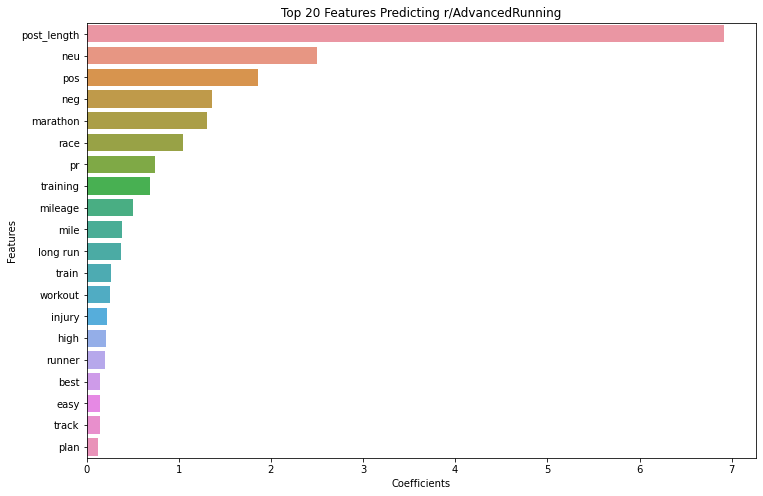

In [105]:
#Graphing top 20 advanced features
top20_advanced=coef_df.sort_values(by='coef', ascending=False).head(20)

plt.figure(figsize=(12,8))
sns.barplot(data=top20_advanced, y=top20_advanced.index, x=top20_advanced['coef'], orient='h')
plt.title('Top 20 Features Predicting r/AdvancedRunning')
plt.ylabel('Features')
plt.xlabel('Coefficients');

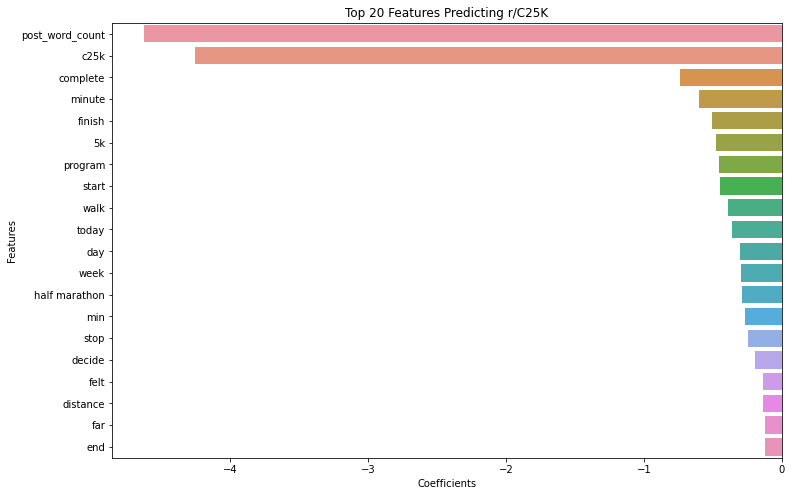

In [99]:
#Top 20 features for c25k 
top20_c25k=coef_df.sort_values(by='coef').head(20)

plt.figure(figsize=(12,8))
sns.barplot(data=top20_c25k, y=top20_c25k.index, x=top20_c25k['coef'], orient='h')
plt.title('Top 20 Features Predicting r/C25K')
plt.ylabel('Features')
plt.xlabel('Coefficients');

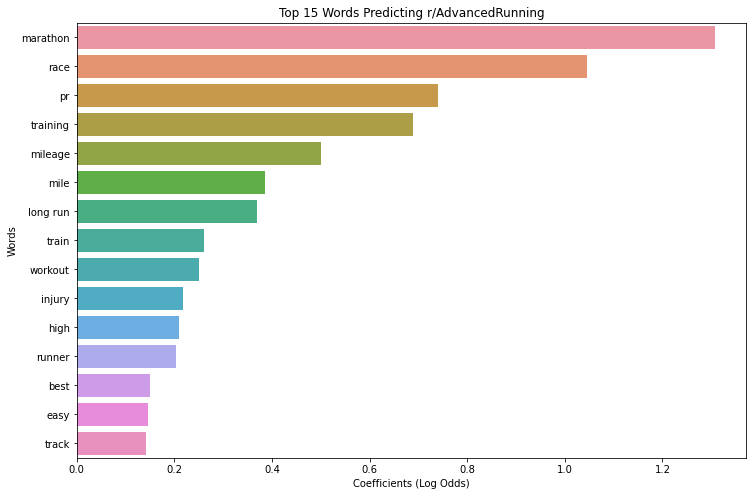

In [111]:
#plotting top 15 advanced words
top20_advanced=coef_df.sort_values(by='coef', ascending=False).head(19)[4:]

plt.figure(figsize=(12,8))
sns.barplot(data=top20_advanced, y=top20_advanced.index, x=top20_advanced['coef'], orient='h')
plt.title('Top 15 Words Predicting r/AdvancedRunning')
plt.ylabel('Words')
plt.xlabel('Coefficients (Log Odds)');

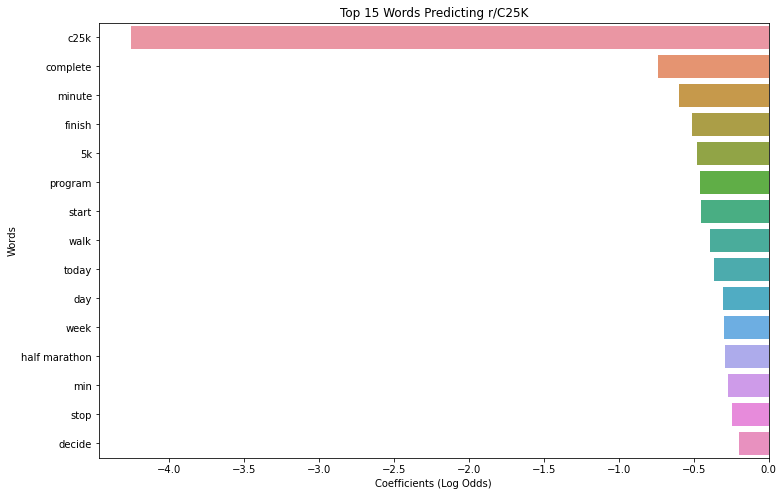

In [110]:
#Top 15 words for c25k
top20_c25k=coef_df.sort_values(by='coef').head(16)[1:]

plt.figure(figsize=(12,8))
sns.barplot(data=top20_c25k, y=top20_c25k.index, x=top20_c25k['coef'], orient='h')
plt.title('Top 15 Words Predicting r/C25K')
plt.ylabel('Words')
plt.xlabel('Coefficients (Log Odds)');

This EDA section has great insights that directly help to answer the problem statement. Please review the conclusions and recommendations in the next section.

---

#### Next Section: Part 5- Modeling and Conclusions